In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from IPython.core.display import display, HTML

%matplotlib inline
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:85% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('max_colwidth', 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 0)
# pd.reset_option('display.float_format')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def fit_sigmoind(df, verbose=False):
    
    x = list(df.iloc[:,0])
    y = list(df.iloc[:,1])
    fit = curve_fit(logistic_model,x,y,p0=[2,100,20000], maxfev=5000)
    # See this on maxfev:
    #https://stackoverflow.com/questions/15831763/scipy-curvefit-runtimeerroroptimal-parameters-not-found-number-of-calls-to-fun
    # Estimates
    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2]

    # Standard Deviation from Covariant matrix
    err_a = np.sqrt(fit[1][0][0])
    err_b = np.sqrt(fit[1][1][1])
    err_c = np.sqrt(fit[1][2][2])
    
    if verbose:
        print(f"a = {round(a,4)}+-{round(err_a,4)}")
        print(f"b = {round(b,4)}+-{round(err_b,4)}")
        print(f"c = {round(c,4)}+-{round(err_c,4)}")
    
    output = [a, b, c]
    return output

In [5]:
basepath = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

## Extract Data from WHO

In [6]:
# POSITIVES
confirmed_fn = "time_series_covid19_confirmed_global.csv"
data = pd.read_csv(basepath + confirmed_fn)
au_pos = data[data["Country/Region"] == "Australia"].drop(columns=["Province/State", "Country/Region", "Lat", "Long"])
au_pos.columns.name = "date"

au_pos = au_pos.sum(axis=0).to_frame().reset_index()
au_pos.columns = ["date", "positives"]
au_pos["timestamp"] = pd.to_datetime(au_pos["date"])

au_pos.drop(columns=["date"], inplace=True)


# DEATHS
deaths_fn = "time_series_covid19_deaths_global.csv"  
data = pd.read_csv(basepath + deaths_fn)
au_dead = data[data["Country/Region"] == "Australia"].drop(columns=["Province/State", "Country/Region", "Lat", "Long"])
au_dead.columns.name = "date"

au_dead = au_dead.sum(axis=0).to_frame().reset_index()
au_dead.columns = ["date", "deaths"]
au_dead["timestamp"] = pd.to_datetime(au_dead["date"])

au_dead.drop(columns=["date"], inplace=True)

In [9]:
# Merge data
dataset = pd.merge(au_pos, au_dead, on="timestamp", how="left")[["timestamp", "positives", "deaths"]]
dataset["dayofyear"] = dataset["timestamp"].dt.dayofyear


# Calculate new positives and growth rate
dataset["new_positives"] = dataset["positives"].diff()

## Growth Rate
dataset["growth_rate"] = dataset["new_positives"]/dataset["new_positives"].shift(1)
dataset = dataset.replace([np.inf, -np.inf], np.nan)

# Average across rolling window
dataset["growth_rate_avg"] = dataset["growth_rate"].rolling(5, win_type=None).mean()
dataset.head(2)

,timestamp,positives,deaths,dayofyear,new_positives,growth_rate,growth_rate_avg
0,2020-01-22,0,0,22,nan,nan,nan
1,2020-01-23,0,0,23,0.000,nan,nan


In [10]:
dataset

,timestamp,positives,deaths,dayofyear,new_positives,growth_rate,growth_rate_avg
0,2020-01-22,0,0,22,nan,nan,nan
1,2020-01-23,0,0,23,0.000,nan,nan
2,2020-01-24,0,0,24,0.000,nan,nan
3,2020-01-25,0,0,25,0.000,nan,nan
4,2020-01-26,4,0,26,4.000,nan,nan
5,2020-01-27,5,0,27,1.000,0.250,nan
6,2020-01-28,5,0,28,0.000,0.000,nan
7,2020-01-29,6,0,29,1.000,nan,nan
8,2020-01-30,9,0,30,3.000,3.000,nan
9,2020-01-31,9,0,31,0.000,0.000,nan


## Calculated new positives

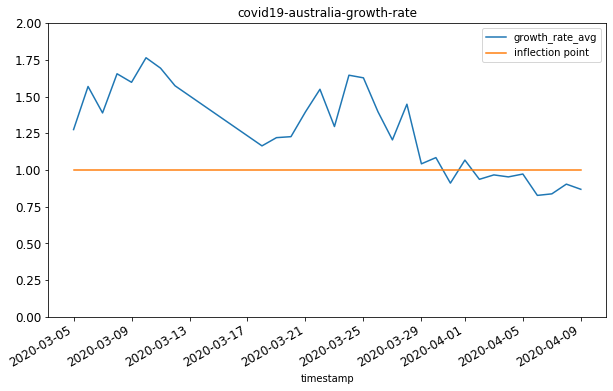

In [11]:
to_plot = dataset.set_index("timestamp")[["growth_rate_avg"]].dropna()
to_plot["inflection point"] = 1

# Plot and save
title = "covid19-australia-growth-rate"
ax = to_plot.plot(ylim=(0, 2), fontsize=12, title = title, figsize=(10,6))
fig = ax.get_figure()
fig.savefig(f"{title}.png")

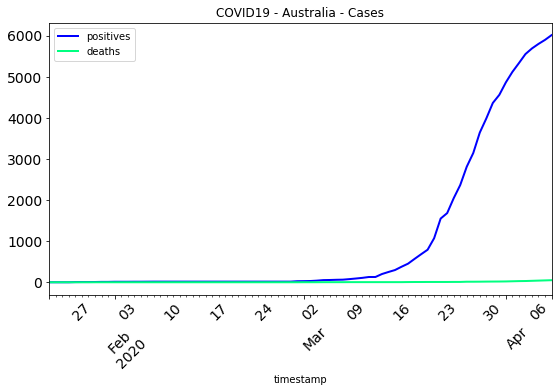

In [7]:
dataset.set_index("timestamp")[["positives", "deaths"]].plot(linewidth=2, 
                                    figsize=(9,5), 
                                    rot=45, 
                                    fontsize=14,
                                    colormap="winter",
                                    title="COVID19 - Australia - Cases")

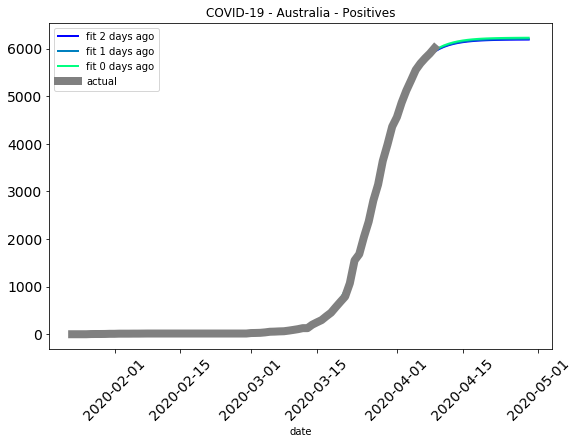

In [8]:
view=dataset
what = "positives"

x = list(range(22,120))
mdodels = pd.DataFrame()

for i in range(2,-1,-1):
    
    if i == 0:
        df = view[["dayofyear", what]]
    else:
        df = view[["dayofyear", what]].iloc[:-i, :]
    # Fit
    [a, b, c] = fit_sigmoind(df)
    # Eval
    yhat = [logistic_model(xi,a,b,c) for xi in x]
    
    mdodels["x"] = x
    mdodels[f"fit {i} days ago"] = yhat

mdodels = mdodels.set_index("x")

# to_plot = national["dayofyear", "totale_casi"]
measured_cases = pd.DataFrame({"x":x,"actual": np.nan})
measured_cases = measured_cases.set_index("x")
measured_cases.loc[list(view["dayofyear"]), "actual"]=list(view[what])

to_plot = pd.merge(mdodels, measured_cases, left_index=True, right_index=True).reset_index()

# Convert to dates
to_plot["date"] = to_plot["x"].apply(lambda x: pd.Timestamp("2020-01-01") + pd.Timedelta(x, unit='d')).dt.date

# set index 
to_plot = to_plot.drop(columns=["x"]).set_index("date")

# plot
this_axis = to_plot.drop(columns=["actual"]).plot(linewidth=2, figsize=(9,6), rot=45, colormap="winter", fontsize=14, title="COVID-19 - Australia - Positives")

this_axis = to_plot[["actual"]].plot(linewidth=8, ax=this_axis, kind="line", color="grey", rot=45)

In [9]:
dataset

,timestamp,positives,deaths,dayofyear,new_positives,growth_rate,growth_rate_avg
0,2020-01-22,0,0,22,nan,nan,nan
1,2020-01-23,0,0,23,0.000,nan,nan
2,2020-01-24,0,0,24,0.000,nan,nan
3,2020-01-25,0,0,25,0.000,nan,nan
4,2020-01-26,4,0,26,4.000,nan,nan
5,2020-01-27,5,0,27,1.000,0.250,nan
6,2020-01-28,5,0,28,0.000,0.000,nan
7,2020-01-29,6,0,29,1.000,nan,nan
8,2020-01-30,9,0,30,3.000,3.000,nan
9,2020-01-31,9,0,31,0.000,0.000,nan
